In [1]:
import llguidance
from guidance import select, gen, user, assistant, system
from guidance.models import OpenAI

/Users/nicholasking/code/ms/guidance/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lm = OpenAI(model="gpt-4o")

In [3]:
with user():
    lm += f"Hi"
with assistant():
    lm += f"{gen(max_tokens=100)}"

In [4]:
lm.engine.tokenizer

In [7]:
from guidance._grammar import string, GrammarFunction, Terminal, Join
import json
import os

In [6]:
grammar = string("brown")
tokenizer = lm.engine.tokenizer

if isinstance(grammar, GrammarFunction):
    # we can't have a terminal as the root
    if isinstance(grammar, Terminal):
        grammar = Join([grammar])
    serialized_grammar = json.dumps(grammar.ll_serialize())
else:
    serialized_grammar = grammar

In [7]:
serialized_grammar

'{"grammars": [{"nodes": [{"String": {"literal": "brown"}}], "rx_nodes": []}]}'

In [8]:
ll_tokenizer = llguidance.LLTokenizer(
    llguidance.TokenizerWrapper(tokenizer)
)

ll_interpreter = llguidance.LLInterpreter(
    ll_tokenizer,
    serialized_grammar,
    log_level=int(os.environ.get("LLGUIDANCE_LOG_LEVEL", "1")),
)

In [9]:
prompt = b"The quick "
preprocessed_toks = tokenizer.encode(prompt)
processed_toks = ll_interpreter.process_prompt(preprocessed_toks)

In [10]:
preprocessed_toks, processed_toks

([976, 4853, 220], [976, 4853, 19705])

In [11]:
tokenizer.decode(processed_toks), tokenizer.decode(preprocessed_toks)

(b'The quick brown', b'The quick ')

In [11]:
from typing import Union
from guidance.models._tokenizer import Tokenizer


def trace_llguidance_process_prompt(grammar: Union[GrammarFunction, str], tokenizer: Tokenizer, prompt: bytes):
    if isinstance(grammar, GrammarFunction):
        # we can't have a terminal as the root
        if isinstance(grammar, Terminal):
            grammar = Join([grammar])
        serialized_grammar = json.dumps(grammar.ll_serialize())
    else:
        serialized_grammar = grammar
    
    print("Serialized grammar:")
    print(serialized_grammar)

    ll_tokenizer = llguidance.LLTokenizer(
        llguidance.TokenizerWrapper(tokenizer)
    )

    ll_interpreter = llguidance.LLInterpreter(
        ll_tokenizer,
        serialized_grammar,
        log_level=2,
    )

    preprocessed_toks = tokenizer.encode(prompt)
    processed_toks = ll_interpreter.process_prompt(preprocessed_toks)

    print("Preprocessed tokens:")
    print(preprocessed_toks) 
    print("Processed tokens:")
    print(processed_toks)

    print("Decoded preprocessed tokens:")
    print(tokenizer.decode(preprocessed_toks))
    print("Decoded processed tokens:")
    print(tokenizer.decode(processed_toks))


In [13]:
from guidance._grammar import Select

prompt = "The quick bro"
tokenizer = lm.engine.tokenizer
g2 = Join([Select([string("wn"), string("ther")]), string("fox jumped ")])

trace_llguidance_process_prompt(g2, tokenizer, prompt.encode())

Serialized grammar:
{"grammars": [{"nodes": [{"Join": {"sequence": [1, 2]}}, {"Select": {"among": [3, 4]}}, {"String": {"literal": "fox jumped "}}, {"String": {"literal": "wn"}}, {"String": {"literal": "ther"}}], "rx_nodes": []}]}
Preprocessed tokens:
[976, 4853, 3714]
Processed tokens:
[976, 4853]
Decoded preprocessed tokens:
b'The quick bro'
Decoded processed tokens:
b'The quick'


Grammar #0:
LexerSpec { lexemes: [
  [0] SKIP  (NoMatch)
  [1] str_n2  (Literal "fox jumped ") contextual
  [2] str_n3  (Literal "wn") contextual
  [3] str_n4  (Literal "ther") contextual
] }
Grammar:
n0              ⇦ n1 n2  
n1              ⇦ n3  
n1              ⇦ n4  
stats: 3 terminals; 2 non-terminals with 3 rules with 11 symbols



  == Optimize ==>
Grammar:
n0              ⇦ n1 n2  
n1              ⇦ n3  
n1              ⇦ n4  
stats: 3 terminals; 2 non-terminals with 3 rules with 11 symbols

build grammar: 15.875µs; optimize: 58.25µs
initial lexer cost: regexps: 4 with 24 nodes (+ 0 derived via 0 derivatives with total fuel 91), states: 3; transitions: 0; bytes: 1899; alphabet size: 16 
prompt: "The‧ quick‧ bro"
prompt+grm: "The‧ quick‧ bro"
force_prefix: " bro"
res_prompt: "The‧ quick"


In [5]:
from guidance import models, gen, select, image, user, assistant, system
from guidance._grammar import string
PHI_3_VISION_MODEL = "microsoft/Phi-3-vision-128k-instruct"

model_kwargs = {
    "_attn_implementation": "eager", # Uncomment this line if flash attention is not working
    "trust_remote_code": True,
    "device_map": "mps",
}
phi3v = models.TransformersPhi3Vision(
    model=PHI_3_VISION_MODEL, **model_kwargs
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



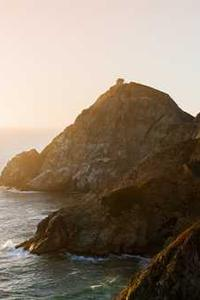

In [6]:
lm = phi3v

with user():
    image_url = "https://picsum.photos/200/300"
    lm += "What do you see in this image?" + image(image_url)

with assistant():
    lm += gen(temperature=0.8)